# Download the RSNA dataset
- RSNA Pneumonia Detection Challenge for predicting whether pneumonia exists in a given image.
- first download the kaggle, follow commands below:
```
cd ~/datasets/
mkdir RSNA_Pneumonia
cd RSNA_Pneumonia
kaggle competitions download -c rsna-pneumonia-detection-challenge
unzip rsna-pneumonia-detection-challenge.zip

```

## Preprocess for classfication/detection.
- orinial rsna annotations, if for each brounding box, change the annotations for each image
- first change the boungdingbox x,y,w,h->x1,y1,x2,y2
- aggregate multiple boxes into one patient.
- group by pateint. 
- make label of patient-level, if have boundingbox, unhealthy:1, otherwise healthy:0
- len of annotations: 30227->26684, because change to pateint level


original-df len: 30227


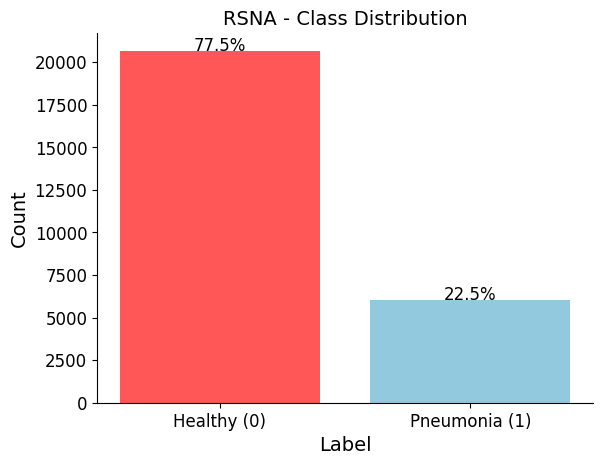

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define dataset folder and annotations file
dataset_folder = '/u/home/galc/datasets/rsna'
image_folder = f'{dataset_folder}/stage_2_train_images'
annotations = 'stage_2_train_labels.csv'

# Load the dataset
df = pd.read_csv(f'{dataset_folder}/{annotations}')
print('original-df len:', len(df))

# Create bounding boxes (x1, y1, x2, y2)
def create_bbox(row):
    if row["Target"] == 0:
        return [0.0, 0.0, 0.0, 0.0]  # Healthy case, bbox is [0, 0, 0, 0]
    else:
        x1 = row["x"]
        y1 = row["y"]
        x2 = x1 + row["width"]
        y2 = y1 + row["height"]
        return [x1, y1, x2, y2]

df["bbox"] = df.apply(lambda x: create_bbox(x), axis=1)

# Aggregate multiple bounding boxes by patientId
df = df[["patientId", "bbox"]]
df = df.groupby("patientId").agg(list)
df = df.reset_index()

# # Replace bounding box lists containing only [[0, 0, 0, 0]] with single [0, 0, 0, 0]
# df["bbox"] = df["bbox"].apply(lambda x: [0, 0, 0, 0] if x == [[0, 0, 0, 0]] else x)

# Create Target column, set to healthy (0) if bbox is [0, 0, 0, 0]
df["Target"] = df["bbox"].apply(lambda x: 0 if x == [[0.0, 0.0, 0.0, 0.0]] else 1)

# Add file path
df["path"] = df["patientId"].apply(lambda x: f"{image_folder}/{x}.dcm")

class_counts = df['Target'].value_counts()
total = class_counts.sum()
percentages = (class_counts / total) * 100

colors = ['#ff5757', '#93c9df']

bars = plt.bar(class_counts.index, class_counts.values, color=colors)
plt.xticks([0, 1], labels=['Healthy (0)', 'Pneumonia (1)'], fontsize=14)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('RSNA - Class Distribution', fontsize=14)

# Add percentages on top of bars
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 15,
             f'{percentage:.1f}%', ha='center', fontsize=12, color='black')

sns.despine(top=True, right=True)

plt.savefig("rsna.pdf", format="pdf", dpi=300)
# plt.show()

# Split the dataset
test_fac = 0.15
train_df, test_val_df = train_test_split(df, test_size=test_fac * 2, random_state=0)
test_df, valid_df = train_test_split(test_val_df, test_size=0.5, random_state=0)

print(f"Number of train samples: {len(train_df)}")
print(f"Number of valid samples: {len(valid_df)}")
print(f"Number of test samples: {len(test_df)}")

# Save to CSV files
RSNA_TRAIN_CSV = '/u/home/galc/VLP-Seminar/annotations/rsna/train.csv'
RSNA_VALID_CSV = '/u/home/galc/VLP-Seminar/annotations/rsna/val.csv'
RSNA_TEST_CSV = '/u/home/galc/VLP-Seminar/annotations/rsna/test.csv'

# Save columns: path, patientId, Target, bbox
train_df.rename(columns={"Target": "label"}, inplace=True)
valid_df.rename(columns={"Target": "label"}, inplace=True)
test_df.rename(columns={"Target": "label"}, inplace=True)

train_df[["path", "patientId", "label", "bbox"]].to_csv(RSNA_TRAIN_CSV, index=False)
valid_df[["path", "patientId", "label", "bbox"]].to_csv(RSNA_VALID_CSV, index=False)
test_df[["path", "patientId", "label", "bbox"]].to_csv(RSNA_TEST_CSV, index=False)

print(f'Train CSV saved to: {RSNA_TRAIN_CSV}')
print(f'Valid CSV saved to: {RSNA_VALID_CSV}')
print(f'Test CSV saved to: {RSNA_TEST_CSV}')

plt.show()

## Balance the data with Undersampling

original-df len: 30227
Balanced dataset size: 12024


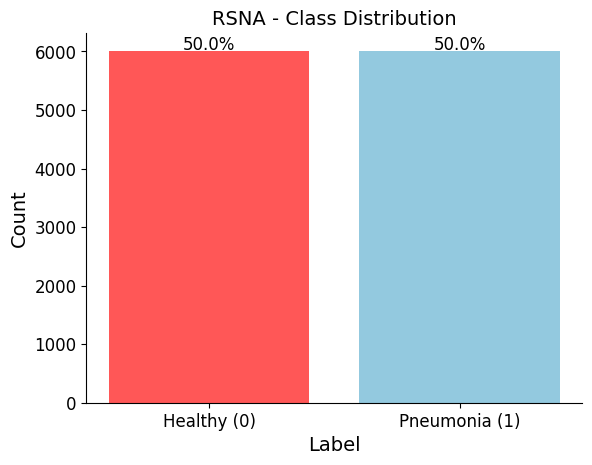

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Define dataset folder and annotations file
dataset_folder = '/u/home/galc/datasets/rsna'
image_folder = f'{dataset_folder}/stage_2_train_images'
annotations = 'stage_2_train_labels.csv'

# Load the dataset
df = pd.read_csv(f'{dataset_folder}/{annotations}')
print('original-df len:', len(df))

# Create bounding boxes (x1, y1, x
# Create bounding boxes (x1, y1, x2, y2)
def create_bbox(row):
    if row["Target"] == 0:
        return [0.0, 0.0, 0.0, 0.0]  # Healthy case, bbox is [0, 0, 0, 0]
    else:
        x1 = row["x"]
        y1 = row["y"]
        x2 = x1 + row["width"]
        y2 = y1 + row["height"]
        return [x1, y1, x2, y2]

df["bbox"] = df.apply(lambda x: create_bbox(x), axis=1)

# Aggregate multiple bounding boxes by patientId
df = df[["patientId", "bbox"]]
df = df.groupby("patientId").agg(list)
df = df.reset_index()

# Create Target column, set to healthy (0) if bbox is [0, 0, 0, 0]
df["Target"] = df["bbox"].apply(lambda x: 0 if x == [[0.0, 0.0, 0.0, 0.0]] else 1)

# Add file path
df["path"] = df["patientId"].apply(lambda x: f"{image_folder}/{x}.dcm")

def balance_classes(df, target_column="Target", sample_size=None):
    min_class_count = df[target_column].value_counts().min()
    sample_size = sample_size or min_class_count

    balanced_df = (
        df.groupby(target_column)
        .apply(lambda x: x.sample(sample_size, replace=len(x) < sample_size, random_state=42))
        .reset_index(drop=True)
    )
    return balanced_df

balanced_df = balance_classes(df)
print(f"Balanced dataset size: {len(balanced_df)}")

class_counts = balanced_df['Target'].value_counts()
total = class_counts.sum()
percentages = (class_counts / total) * 100

colors = ['#ff5757', '#93c9df']

# Plot the class imbalance
bars = plt.bar(class_counts.index, class_counts.values, color=colors)
plt.xticks([0, 1], labels=['Healthy (0)', 'Pneumonia (1)'], fontsize=14)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('RSNA - Class Distribution', fontsize=14)

# Add percentages on top of bars
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 15,
             f'{percentage:.1f}%', ha='center', fontsize=12, color='black')

sns.despine(top=True, right=True)

plt.savefig("balanced_rsna.pdf", format="pdf", dpi=300)
# plt.show()

# Split the dataset into train, validation, and test sets
test_fac = 0.15
train_df, test_val_df = train_test_split(balanced_df, test_size=test_fac * 2, stratify=balanced_df["Target"], random_state=0)
test_df, valid_df = train_test_split(test_val_df, test_size=0.5, stratify=test_val_df["Target"], random_state=0)
print(f"Number of train samples: {len(train_df)}")
print(f"Number of valid samples: {len(valid_df)}")
print(f"Number of test samples: {len(test_df)}")
# Save to CSV files
base_path = '/u/home/galc/VLP-Seminar/annotations/rsna/balanced/'

RSNA_TRAIN_CSV = base_path + 'train.csv'
RSNA_VALID_CSV = base_path + 'val.csv'
RSNA_TEST_CSV = base_path + 'test.csv'

train_df.rename(columns={"Target": "label"}, inplace=True)
valid_df.rename(columns={"Target": "label"}, inplace=True)
test_df.rename(columns={"Target": "label"}, inplace=True)

train_df[["path", "patientId", "label", "bbox"]].to_csv(RSNA_TRAIN_CSV, index=False)
valid_df[["path", "patientId", "label", "bbox"]].to_csv(RSNA_VALID_CSV, index=False)
test_df[["path", "patientId", "label", "bbox"]].to_csv(RSNA_TEST_CSV, index=False)

print(f'Train CSV saved to: {RSNA_TRAIN_CSV}')
print(f'Valid CSV saved to: {RSNA_VALID_CSV}')
print(f'Test CSV saved to: {RSNA_TEST_CSV}')

plt.show()